<a href="https://colab.research.google.com/github/mantingsun0/colab0/blob/main/K_Means_Clustering_on_Image_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import os
import cv2
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from skimage.feature import hog
from collections import Counter


from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


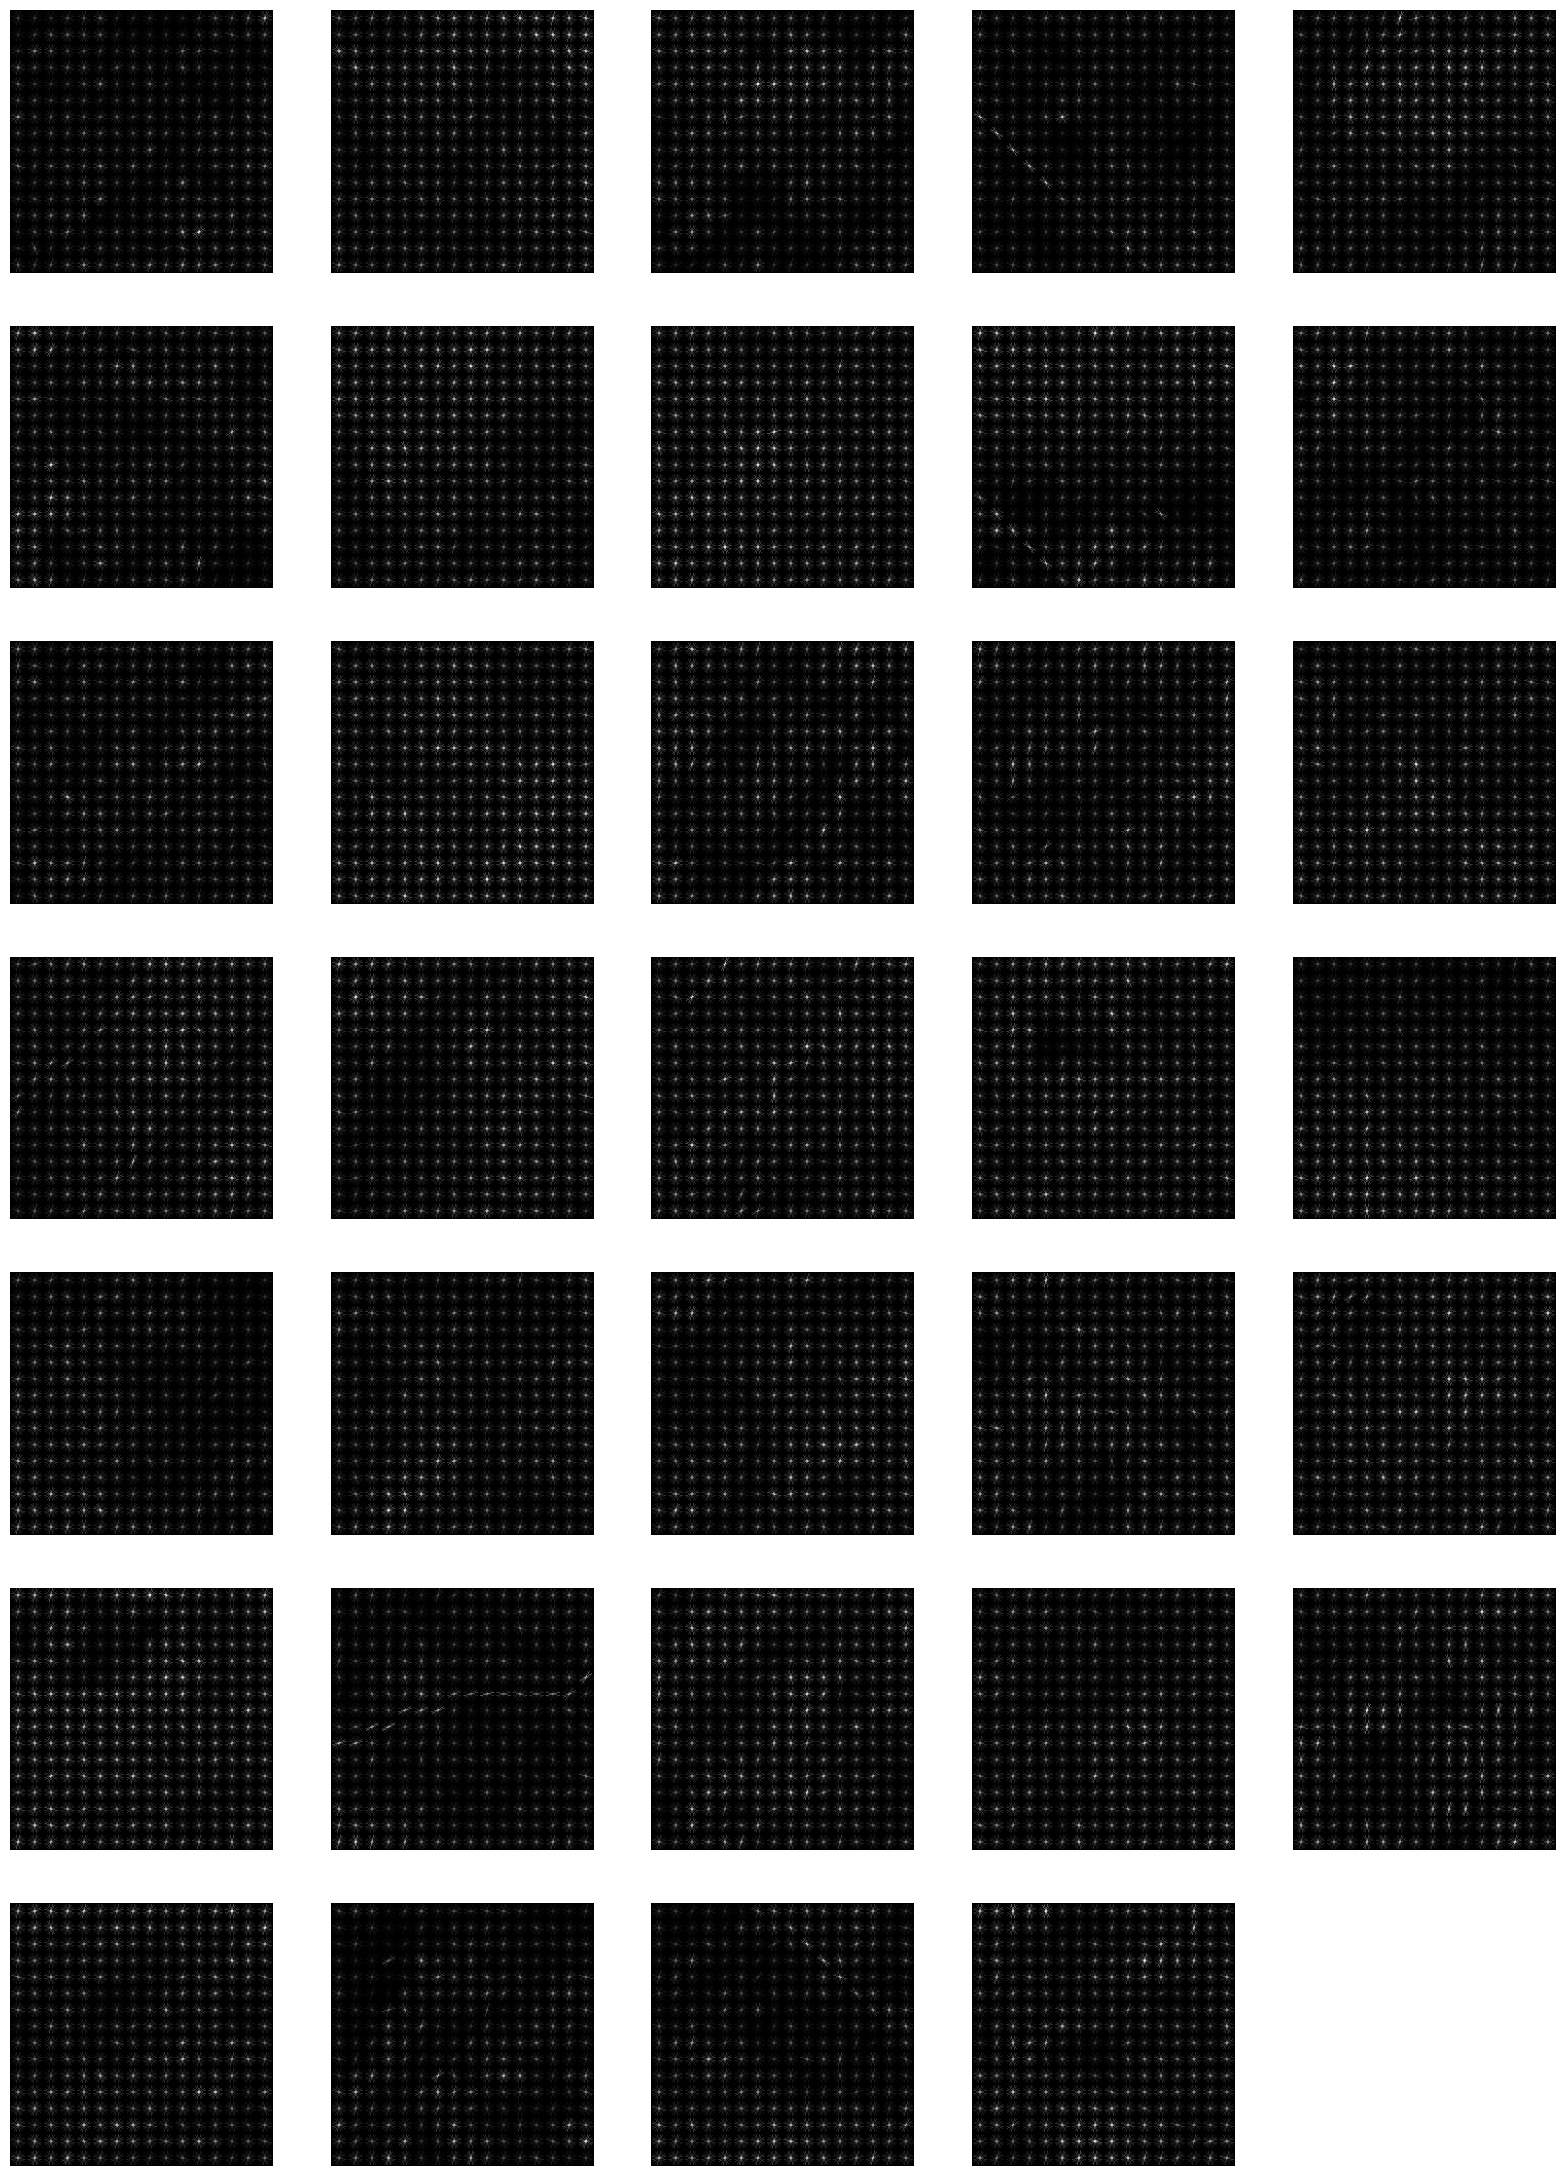

In [10]:
# Read the image and extract features
def extract_features(image_path, feature_type):
    image = cv2.imread(image_path)
    if feature_type == 'hu':
        # Use Hu moments as features
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        moments = cv2.moments(gray)
        features = cv2.HuMoments(moments).flatten()
    elif feature_type == 'hog':
        # Use HOG features
        # Use HOG features
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        features, hog_image = hog(gray, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), block_norm='L2-Hys', visualize=True)
        return features, hog_image
    else:
        # Use colour histogram as features
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        hist = cv2.calcHist([hsv], [0, 1], None, [180, 256], [0, 180, 0, 256])
        cv2.normalise(hist, hist)
        features = hist.flatten()
    return features, None

# Read all images
image_folder = '/content/drive/My Drive/kmeans_test'
image_paths = [os.path.join(image_folder, image) for image in os.listdir(image_folder)]
# Set to 'hist' to use colour histogram, set to 'hu' to use Hu moments, set to 'hog' to use HOG features
feature_type = 'hog' #@param ['hist', 'hu', 'hog'] {type:'string'}
features = []
hog_images = []
for image_path in image_paths:
    feature, hog_image = extract_features(image_path, feature_type)
    features.append(feature)
    hog_images.append(hog_image)
features = np.array(features)

# Preview all images
n = len(image_paths)
cols = 5
rows = math.ceil(n / cols)
plt.figure(figsize=(20, 4 * rows))
for i, image_path in enumerate(image_paths):
    plt.subplot(rows, cols, i+1)
    if feature_type == 'hog' and hog_images[i] is not None:
        image = hog_images[i]
        plt.imshow(image, cmap='gray')
    else:
        image = cv2.imread(image_path)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
plt.show()

All k values are: [6, 4, 3, 7, 3, 7, 5, 2, 7, 6, 7, 2, 7, 5, 5, 5, 7, 7, 7, 3, 7, 5, 3, 4, 5, 6, 4, 3, 3, 6]
The best k value is: 7


<ipython-input-11-6641556a276d>:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('inferno', 30)
<ipython-input-11-6641556a276d>:34: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(range(1,9), SSE, '-o', marker='x', color=color, label=f'Run {i+1}', linewidth=0.5)


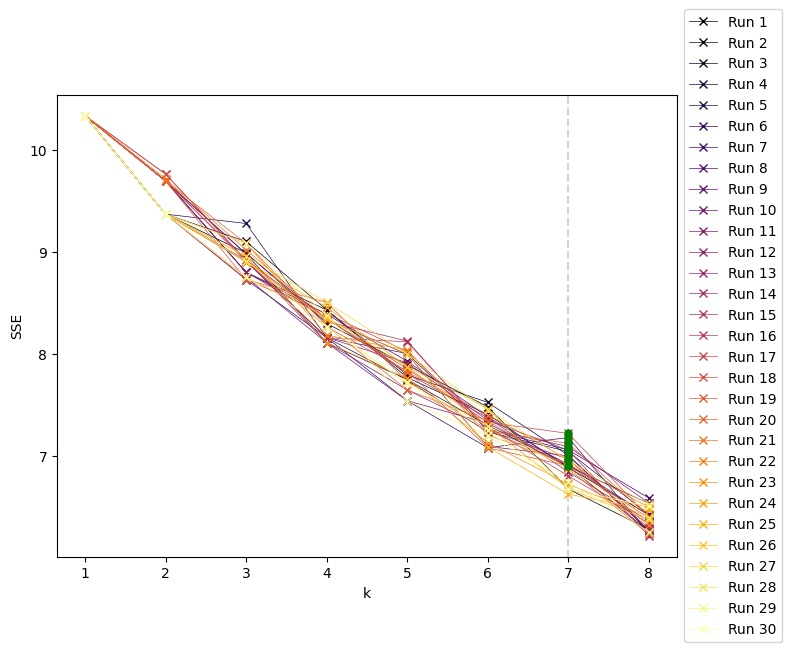

In [11]:
# Use SSE to select k
best_k_values = [] # Store the best k value for each run
SSEs = [] # Store the SSE for each k value
for _ in range(30):
    SSE = [] # Store the sum of squared errors for each result
    for k in range(1,9):
        estimator = KMeans(n_clusters=k, n_init=10) # Construct the classifier
        estimator.fit(features)
        SSE.append(estimator.inertia_)
    best_k = np.argmin(np.diff(SSE,2)) + 2
    best_k_values.append(best_k)
    SSEs.append(SSE)

# Print all k values
print(f"All k values are: {best_k_values}")

# Find the most common k value
counter = Counter(best_k_values)
best_k = counter.most_common(1)[0][0]

print(f"The best k value is: {best_k}")

# Create a colour map
cmap = plt.cm.get_cmap('inferno', 30)

# Plot the line graph
fig, ax = plt.subplots(figsize=(10, 6))

# Draw a light grey vertical dashed line at the best k value
ax.axvline(x=best_k, linestyle='--', color='lightgray')

for i, SSE in enumerate(SSEs):
    color = cmap(i)
    ax.plot(range(1,9), SSE, '-o', marker='x', color=color, label=f'Run {i+1}', linewidth=0.5)

ax.set_xlabel('k')
ax.set_ylabel('SSE')

# Draw a red marker at the best k value in the line graph
for i, best_k_value in enumerate(best_k_values):
    if best_k_value == best_k:
        ax.plot(best_k_value, SSEs[i][best_k_value-1], 'green', marker='o', markersize=5)

# Move the legend to the right and make it the same height as the chart
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [12]:
# K-means clustering
kmeans = KMeans(n_clusters=best_k,  n_init='auto').fit(features)
labels = kmeans.labels_

# Add labels to the original data frame
df = pd.DataFrame()
df['labels'] = kmeans.labels_

# Save the data frame to a CSV file
df.to_csv('/content/drive/My Drive/kmeans_test/kmeans_output.csv', index=False)


<ipython-input-15-6cc4c302d12a>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', best_k)


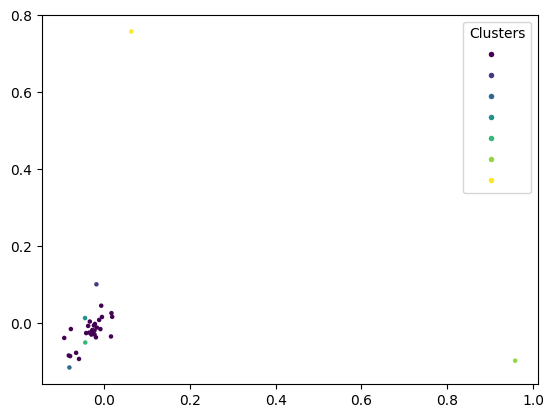

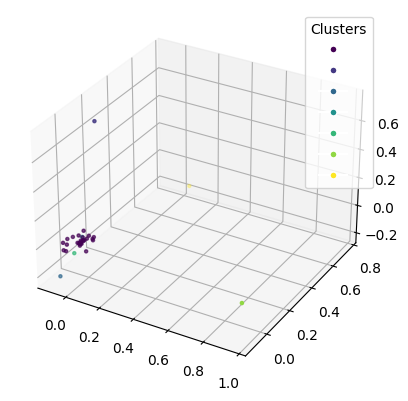

In [15]:
# If the dimensionality of the features is greater than 3, we use PCA for dimensionality reduction
if features.shape[1] > 3:
    pca = PCA(n_components=3)
    features = pca.fit_transform(features)

from matplotlib.lines import Line2D

# Create a colour map
cmap = plt.cm.get_cmap('viridis', best_k)

# 2D visualisation
scatter = plt.scatter(features[:, 0], features[:, 1], s=5, c=labels, cmap=cmap)
# Create handles for the legend
legend1_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i/best_k), markersize=5) for i in range(best_k)]
plt.legend(handles=legend1_handles, title="Clusters")
plt.show()

# 3D visualisation
if features.shape[1] > 2:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # Scatter plot for 3D data
    scatter = ax.scatter(features[:, 0], features[:, 1], features[:, 2], s=5, c=labels, cmap=cmap)
    # Create handles for the legend
    legend2_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i/best_k), markersize=5) for i in range(best_k)]
    ax.legend(handles=legend2_handles, title="Clusters")
    plt.show()


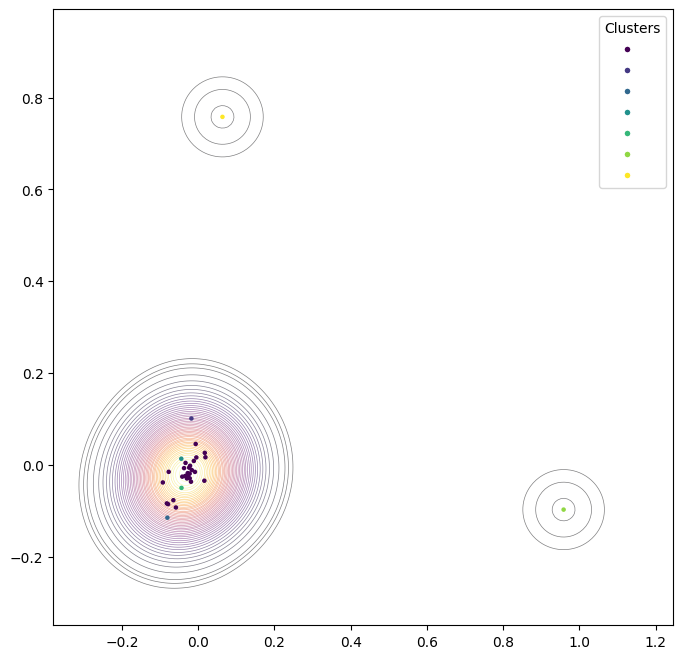

In [16]:
# Assuming you have two dimensions in your features
x = features[:, 0]
y = features[:, 1]

# Create a new figure
plt.figure(figsize=(8, 8))

# Combine x and y into a two-dimensional array
data = np.vstack([x, y]).T

# First, plot the Kernel Density Estimation
sns.kdeplot(x=data[:, 0], y=data[:, 1], cmap="inferno", fill=False, levels=50, thresh=0.05, linewidths=0.5, alpha=0.5, zorder=1)

# Then, plot the scatter plot
scatter = plt.scatter(x, y, s=5, c=labels, cmap=cmap)
# Create legend handles for the clusters
legend1_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i/best_k), markersize=5) for i in range(best_k)]
plt.legend(handles=legend1_handles, title="Clusters")

plt.show()


<ipython-input-17-c472b63e23c8>:14: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=cluster_data[:, 0], y=cluster_data[:, 1], cmap="inferno", fill=False, levels=50, thresh=0.05, linewidths=0.5, alpha=0.5, zorder=1)
<ipython-input-17-c472b63e23c8>:14: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=cluster_data[:, 0], y=cluster_data[:, 1], cmap="inferno", fill=False, levels=50, thresh=0.05, linewidths=0.5, alpha=0.5, zorder=1)
<ipython-input-17-c472b63e23c8>:14: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=cluster_data[:, 0], y=cluster_data[:, 1], cmap="inferno", fill=False, levels=50, thresh=0.05, linewidths=0.5, alpha=0.5, zorder=1)
<ipython-input-17-c472b63e23c8>:14: UserWarning: KDE cannot be estimated (0 

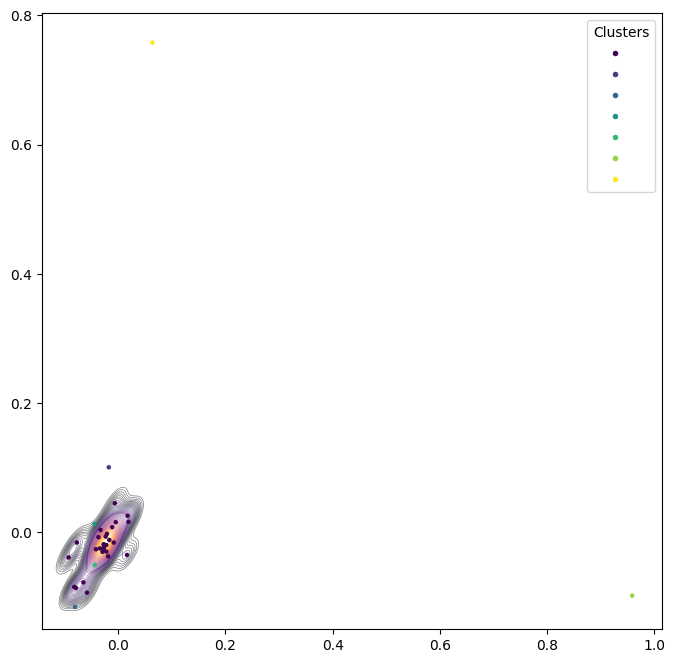

In [17]:
# Assuming you have two dimensions in your features
x = features[:, 0]
y = features[:, 1]

# Create a new figure
plt.figure(figsize=(8, 8))

# Combine x and y into a two-dimensional array
data = np.vstack([x, y]).T

# Plot Kernel Density Estimation for each cluster separately
for i in range(best_k):
    cluster_data = data[labels == i]
    sns.kdeplot(x=cluster_data[:, 0], y=cluster_data[:, 1], cmap="inferno", fill=False, levels=50, thresh=0.05, linewidths=0.5, alpha=0.5, zorder=1)

# Then, plot the scatter plot
scatter = plt.scatter(x, y, s=5, c=labels, cmap=cmap)
# Create legend handles for the clusters
legend1_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i/best_k), markersize=5) for i in range(best_k)]
plt.legend(handles=legend1_handles, title="Clusters")

plt.show()


In [20]:
import shutil


In [22]:
# Directory where the images are located
image_folder = '/content/drive/My Drive/kmeans_test'

# Directory where you want to save the clustered images
output_folder = '/content/drive/My Drive/kmeans_clusters'

# Create the output directory if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Create subdirectories for clusters
for i in range(best_k):
    cluster_subdir = os.path.join(output_folder, f'Cluster_{i}')
    if not os.path.exists(cluster_subdir):
        os.makedirs(cluster_subdir)

# Copy images to their respective cluster directories
for image_path, cluster_label in zip(image_paths, labels):
    # Determine the filename and the target directory
    filename = os.path.basename(image_path)
    target_dir = os.path.join(output_folder, f'Cluster_{cluster_label}')
    target_path = os.path.join(target_dir, filename)

    # Copy the image
    shutil.copy(image_path, target_path)

print(f'Images have been copied into {best_k} cluster directories.')


Images have been copied into 7 cluster directories.
